# Sizing for Measurement Amplifier 

**Copyright 2024 Harald Pretl**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

In [1]:
# read table data
from pygmid import Lookup as lk
import numpy as np
lv_pmos = lk('sg13_lv_pmos.mat')
# list of parameters: VGS, VDS, VSB, L, W, NFING, ID, VT, GM, GMB, GDS, CGG, CGB, CGD, CGS, CDD, CSS, STH, SFL
# if not specified, minimum L, VDS=max(vgs)/2=0.9 and VSB=0 are used 

In [2]:
# define the specified values
Av_spec = 1
Rl_spec = 50 # Ohm
gm_spec = Av_spec / (Rl_spec/2)
gm_id_spec = 8
L_spec = 0.13 # um
Vdd = 1.5 # V

In [3]:
# we can calculate the bias current ID directly
id = gm_spec / gm_id_spec
print('Id =', round(id/1e-3, 3), 'mA')

Id = 5.0 mA


In [4]:
# find the W of the transistor
vout_dc = Rl_spec/2*id
id_w = lv_pmos.lookup('ID_W', GM_ID=gm_id_spec, L=L_spec, VDS=(Vdd-vout_dc), VSB=0)
w = id / id_w
w_round = round(w/10,0)*10
print('W =', round(w, 2), 'um, rounded W =', w_round, 'um')

W = 264.3 um, rounded W = 260.0 um


In [5]:
vgs = lv_pmos.look_upVGS(GM_ID=gm_id_spec, L=L_spec, VDS=(Vdd-vout_dc), VSB=0.0)
print ('Vgs =', round(float(vgs),3), 'V')

Vgs = 0.601 V


In [6]:
# the gm_gds we look up and calculate gds from it
gm_gds = lv_pmos.lookup('GM_GDS', GM_ID=gm_id_spec, L=L_spec, VDS=(Vdd-vout_dc), VSB=0)
gds = gm_spec / gm_gds
# calculate the effective load impedance taking gds into account
Rload = 1/(2/Rl_spec + gds)
print('Rload =', round(Rload, 1), 'Ohm')
Av = gm_spec * Rload
print('Av =', round(20*np.log10(Av),1), 'dB')
cin = gm_spec*lv_pmos.lookup('CGG_GM', GM_ID=gm_id_spec, L=L_spec, VDS=(Vdd-vout_dc), VSB=0)
print('Cin =', round(float(cin)/1e-15), 'fF')

Rload = 23.8 Ohm
Av = -0.4 dB
Cin = 351 fF


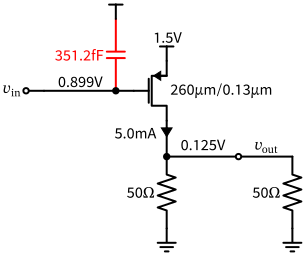

In [7]:
# draw the final circuit with calculated values
#| label: fig-meas-amp-sized
#| fig-cap: Measurement amplifier with calculated circuit sizing.
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing(canvas='svg') as d:
    d.config(unit=2)
    d.config(fontsize=16)
    elm.Vdd().label(str(Vdd)+'V')
    M1 = elm.AnalogPFet(offset_gate=False).drop('drain').theta(0).reverse().label(str(round(w_round))+'µm/'+str(round(L_spec,2))+'µm', loc='right')
    drainline = elm.Line().down().length(1)
    elm.CurrentLabelInline(direction='in', ofst=-0).at(drainline).label(str(id/1e-3)+'mA')
    d.push()
    elm.Line().right().dot(open=True).length(2).idot().label(str(id*50/2)+'V')
    elm.Line().right().length(1.5).label(r'$v_\mathrm{out}$')
    Rload = elm.Resistor().down().label(str(Rl_spec)+r'$\Omega$')
    elm.Ground()
    d.pop()
    R1 = elm.Resistor().down().label(str(Rl_spec)+r'$\Omega$')
    elm.Ground()
    elm.Line().left().at(M1.gate).length(0.5).dot()
    d.push()
    Cin = elm.Capacitor().up().label(str(round(cin/1e-15,1))+'fF').color('red')
    elm.Vdd()
    d.pop()
    elm.Line().left().length(2).label(str(round(Vdd-vgs,3))+'V')
    elm.Line().left().dot(open=True).length(0.5).label(r'$v_\mathrm{in}$', 'left')